In [79]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['Rose','Sunflower'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [80]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                               ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])
#Load the training data
trainset = datasets.ImageFolder("flowers-dataset/train", transform=train_transforms)
testset = datasets.ImageFolder("flowers-dataset/test", transform=test_transforms)

traindata = torch.utils.data.DataLoader(trainset, batch_size=32)
testdata = torch.utils.data.DataLoader(testset, batch_size=32)

<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
torch.Size([32])


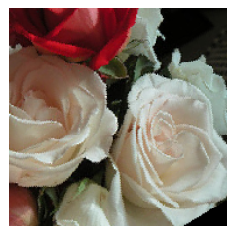

In [81]:
# A little test
images, labels = next(iter(traindata))
print(type(images))
print(images.shape)
print(labels.shape)
imshow(images[0], normalize=False)

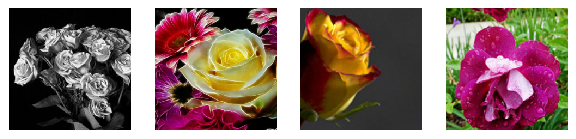

In [82]:
#An othertest
data_iter = iter(testdata)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize = (10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

In [83]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        #self.cf1 = nn.Linear(3*224*224, 128)
        self.cf1 = nn.Linear(50176, 16384)
        self.cf2 = nn.Linear(16384, 8192)
        self.cf3 = nn.Linear(8192, 4096)
        self.cf4 = nn.Linear(4096, 2048)
        self.cf5 = nn.Linear(2048, 1024)
        self.cf6 = nn.Linear(1024, 512)
        self.cf7 = nn.Linear(512, 256)
        self.cf8 = nn.Linear(256, 128)
        self.cf9 = nn.Linear(128, 64)
        self.cf10 = nn.Linear(64, 2)
        # dropout with the prob of 0.2
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        #flatten inputs
        x = x.view(x.shape[0],-1)
        #x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.cf1(x)))
        x = self.dropout(F.relu(self.cf2(x)))
        x = self.dropout(F.relu(self.cf3(x)))
        x = self.dropout(F.relu(self.cf4(x)))
        x = self.dropout(F.relu(self.cf5(x)))
        x = self.dropout(F.relu(self.cf6(x)))
        x = self.dropout(F.relu(self.cf7(x)))
        x = self.dropout(F.relu(self.cf8(x)))
        x = self.dropout(F.relu(self.cf9(x)))
        
        # output so no drop out hehe
        x = F.log_softmax(self.cf10(x), dim=1)
        
        return x

In [84]:
model = Classifier()
criterion = nn.NLLLoss()
optimization = optim.Adam(model.parameters(), lr=0.003)

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 3288334336 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
# Training my network
epoches = 2
for e in range(epoches):
    runing_loss = 0
    for images, labels in traindata: 
        images = images.view(1, -1) 
        log_ps = model(images)
        loss = criterion(log_ps, labels)

        # Todo training pass
        optimization.zero_grad()
        
         #flatten images
        #images = images.view(images.shape[0], -1)
        #output = model.forward(images)
        loss.backward()
        
        optimization.step()
        
        runing_loss += loss.item()
    else:
        print("training loss: ", runing_loss )
       